HACKDAY CDS - TIME 1

# PROJECT SOLUTION PLANNING

A mobilidade tem um papel fundamental no dia a dia da população de qualquer país, e no Brasil, o cenário não é diferente. Novas formas de abordar o tema têm se popularizado cada vez mais nos últimos anos, como o aumento de práticas de aluguel de veículos, e a busca dos consumidores por locações de veículos por assinatura.

Segundo a Associação Brasileira das Locadoras de Automóveis (ABLA), o faturamento bruto do segmento, que tem no Brasil 13.903 locadoras ativas, deu um salto de 33,5% no ano de 2021, e chegou ao recorde de R$ 23,5 bilhões.¹

Ainda segundo a mesma matéria da ABLA, em 2021, as locadoras compraram 441.858 carros zero quilômetro, equivalentes a 25,5% de todos os automóveis emplacados no ano. Houve portanto um crescimento de 22,5% em relação às compras feitas em 2020 (360.567 unidades).

Junto ao aumento da frota de veículos, aumenta também a necessidade de um incremento na venda dos seminovos por parte das locadoras. Isto garante a viabilidade do negócio, visto que:

Aumenta o poder de barganha na aquisição de novos veículos junto as montadoras.
Evita custos de manutenção cada vez mais altos, em decorrência do desgaste dos veículos ao longo do tempo.
Mantém a frota atualizada com relação as novas tecnologias presentes nos novos veículos.
Reforça uma postura sustentável da empresa, com veículos projetados cada vez mais com foco na sustentabilidade.
Este desafio aborda o case da locadora Mobility Cars, tradicional player do segmento de locação de veículos, presente em todo o território brasileiro.

A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.

A empresa utiliza hoje como referência de valores de veículos a tabela FIPE², amplamente difundida no mercado nacional. Porém, é comum esta referência não ser assertiva para definir o valor real praticado pelo mercado, a depender da marca e modelo do veículo.

O objetivo desta competição é desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

A diretoria comercial da Mobility Cars, está convicta de que a nova tabela de referência será a peça chave para reverter o quadro negativo atual. Com ela, a empresa voltará a atingir as metas de vendas de seminovos estipuladas, retomando sua posição de destaque no mercado.

Materiais & Referências:

1 - ABLA- Estatísticas do aluguel de veículos em 2021
2 - Tabela FIPE

## Input

1. Business problem
    - A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.
    
2. Datasets:

    - **treino.csv**
    - **teste.csv**


## Output


- Desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

1. Deliverables:

- Model's performance and results report with the following topics:
    - Preço por ID

## Tasks

**Project Development Method**

The project was developed based on the CRISP-DS (Cross-Industry Standard Process - Data Science, a.k.a. CRISP-DM) project management method, with the following steps:

- Project Planning
- Business Understanding;
- Data Collection;
- Data Cleaning;
- Exploratory Data Analysis (EDA);
- Data Preparation;
- Machine Learning Modelling and fine-tuning;
- Model and Business performance evaluation / Results;
- Model deployment.


<img src="https://www.researchgate.net/profile/Youssef-Tounsi-2/publication/341627969/figure/fig1/AS:903550875996160@1592434724532/CRISP-DM-data-mining-framework.png" alt="some text" width=500 height=400 align="left">


# Imports

In [221]:
import math
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import datetime
import inflection
import warnings
import random
import pickle
import json

import xgboost               as xgb
import lightgbm              as lgbm
    
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from boruta                  import BorutaPy

from IPython.core.display    import HTML
from IPython.display         import Image

# Versão da Linguagem Python
from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
warnings.filterwarnings( 'ignore' )

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.2


## Helper Functions

In [226]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# Define the function to evaluate the models
def weighted_mean_absolute_error(df, y, yhat):
    weights = df.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-yhat))/(np.sum(weights)), 2)

def ml_error( df,model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse}, index=[0])

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'mean_absolute_error': 'mean_absolute_error',
               'mean_squared_error': 'mean_squared_error',
               'r2_score': 'r2_score'}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)
    
    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance


In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# LOADING DATA

In [4]:
#project home path for importing files
home_path = '/home/marxcerqueira/repos/hackday-cds-time1/'

#loading datasets available for this project
df_treino              = pd.read_csv(home_path + 'data/treino.csv', low_memory = False)
df_teste               = pd.read_csv(home_path + 'data/teste.csv', low_memory = False)
df_sample_submission   = pd.read_csv(home_path + 'data/sample_submission.csv', low_memory = False)


# DATA DISCRIPTION

In [5]:
#Copy dataset
df1 = df_treino.copy()

## Rename Columns

In [6]:
# checking columns
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [ ]:
# columns = ['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao','ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado','cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor','tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao','attr_veiculo_aceita_troca', 'attr_veiculo_único_dono','attr_veiculo_todas_as_revisões_feitas_pela_concessionária','attr_veiculo_ipva_pago', 'attr_veiculo_licenciado','attr_veiculo_garantia_de_fábrica','attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro','attr_veiculo_alienado', 'preco']

## Data Dimension

In [7]:
# checking data dimesions to see if we have enough computational power
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 39446
Number of Cols: 29


## Data Types

In [8]:
# checking features dtypes
df1.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NA Values

In [11]:
# checking NA values sum and its percentagem from total number of rows
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
ID,0,0.00
num_fotos,237,0.60
marca,0,0.00
modelo,0,0.00
versao,0,0.00
ano_de_fabricacao,0,0.00
ano_modelo,0,0.00
odometro,0,0.00
cambio,0,0.00
num_portas,0,0.00


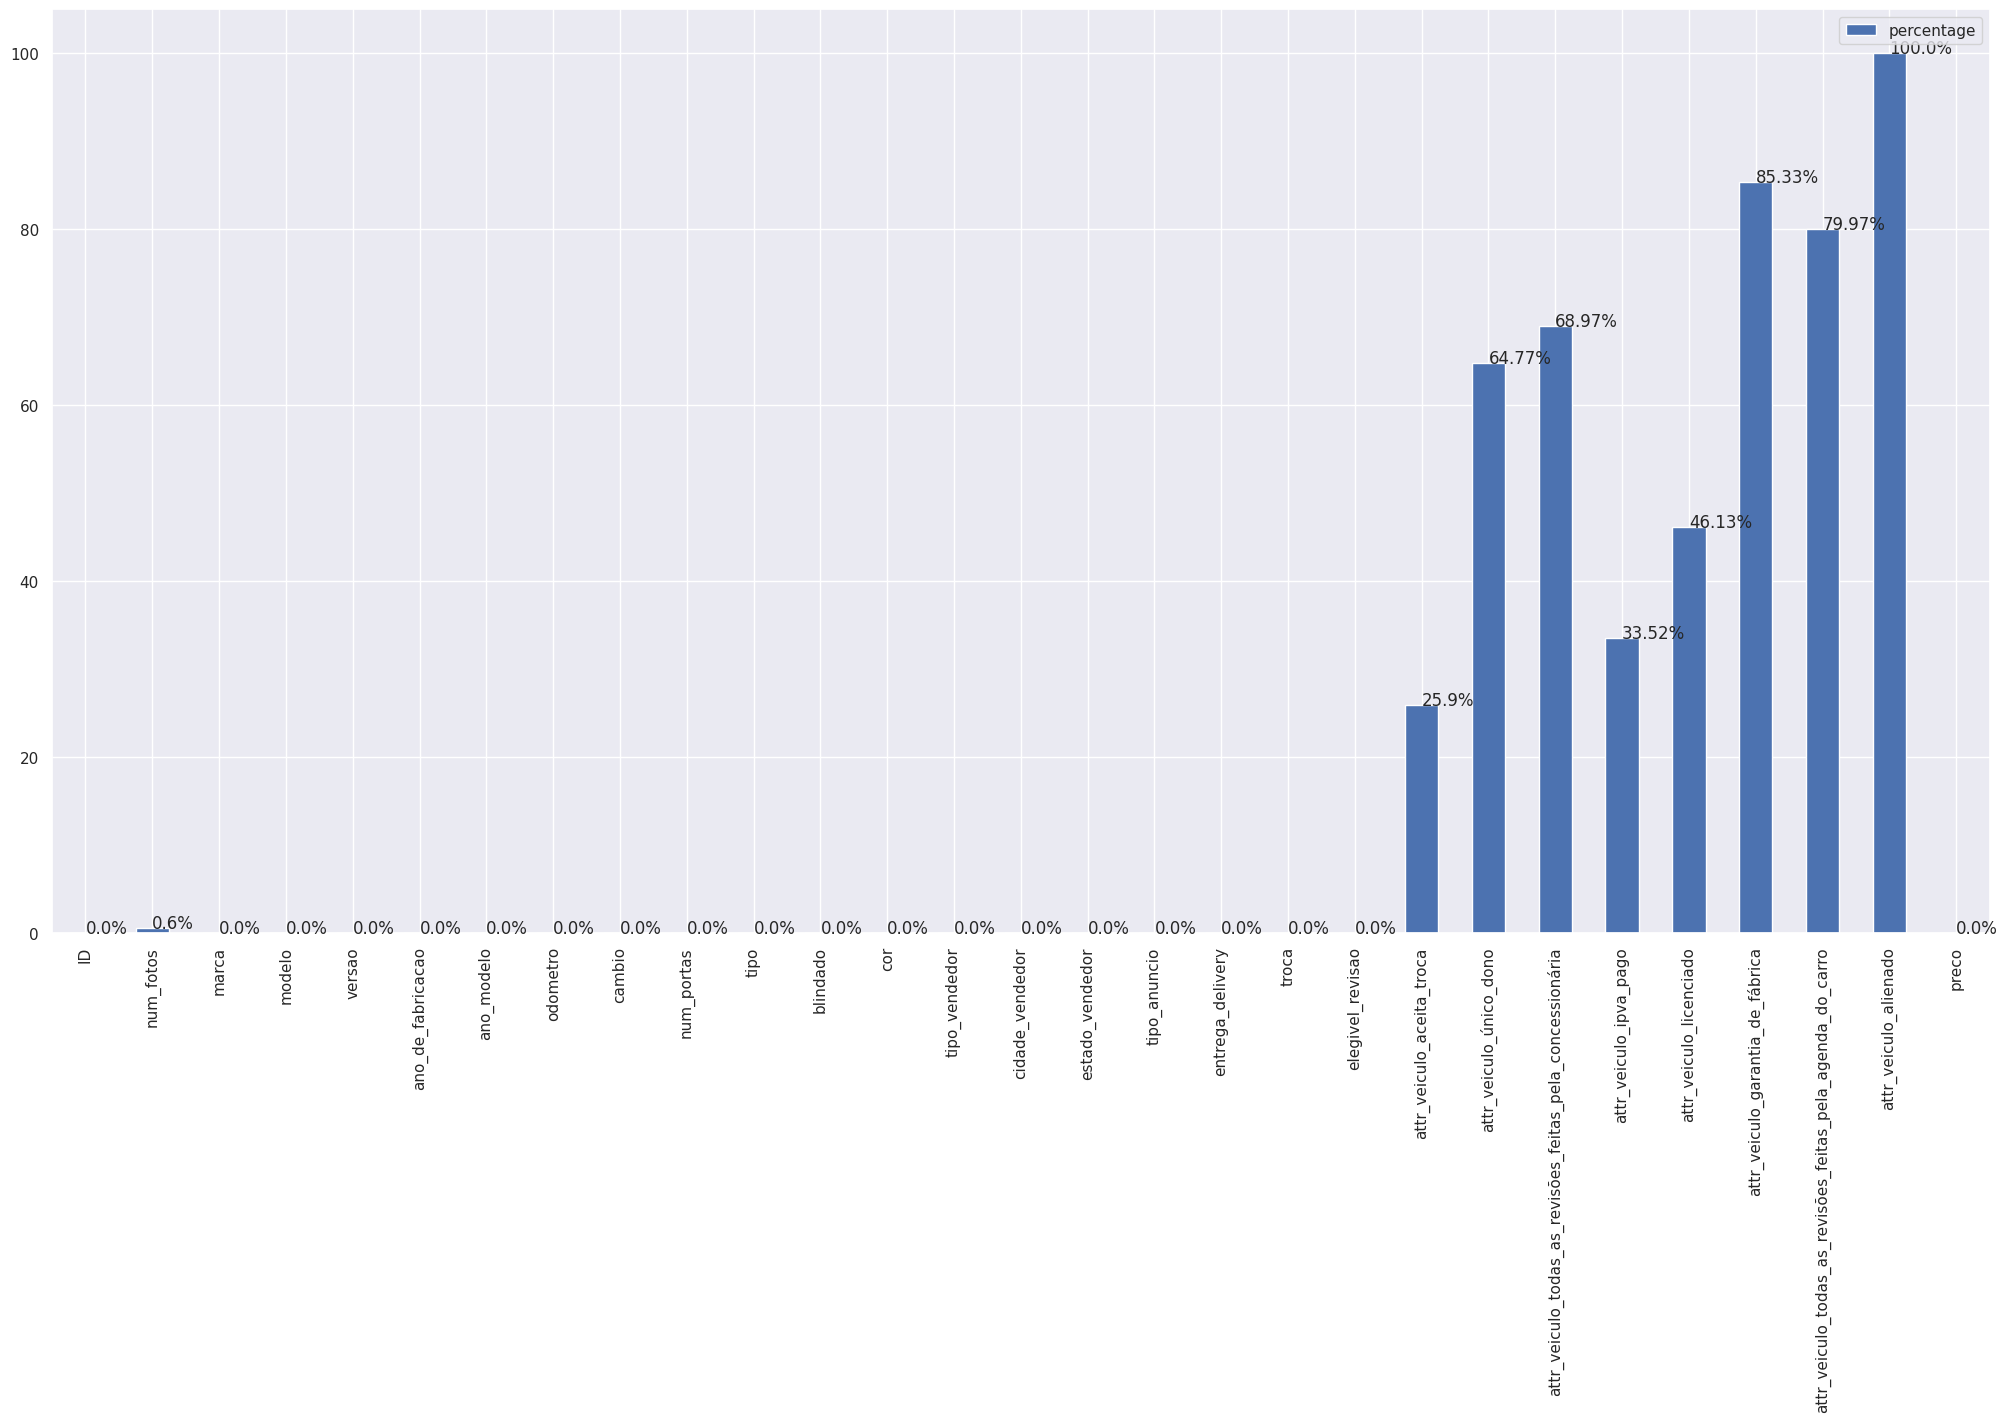

In [12]:
# missing na chart
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

## Fillout NA

In [13]:
# assumptions:
# valores NAs são 0
df1['num_fotos'] = df1['num_fotos'].fillna(0)

#entrega_delivery
df1['entrega_delivery'] = df1['entrega_delivery'].apply(lambda x: 1 if x==True else 0)

# troca
df1['troca'] = df1['troca'].apply(lambda x: 1 if x==True else 0)

# elegivel_revisao
df1['elegivel_revisao'] = df1['elegivel_revisao'].apply(lambda x: 1 if x==True else 0)

# converting to binary data
# attr_veiculo_aceita_troca
df1['attr_veiculo_aceita_troca'] = pd.get_dummies(df1['attr_veiculo_aceita_troca'])

# 'attr_veiculo_único_dono'
df1['attr_veiculo_único_dono'] = pd.get_dummies(df1['attr_veiculo_único_dono'])

# 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária'
df1['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = pd.get_dummies(df1['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'])

# 'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
df1['attr_veiculo_ipva_pago'] = pd.get_dummies(df1['attr_veiculo_ipva_pago'])

# attr_veiculo_licenciado
df1['attr_veiculo_licenciado'] = pd.get_dummies(df1['attr_veiculo_licenciado'])

# 'attr_veiculo_garantia_de_fábrica',
df1['attr_veiculo_garantia_de_fábrica'] = pd.get_dummies(df1['attr_veiculo_garantia_de_fábrica'])

# 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
df1['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = pd.get_dummies(df1['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])


In [14]:
df1.dtypes # checking datatypes transformation

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Change Types

In [16]:
df1 = df1.astype({'attr_veiculo_aceita_troca':'int64',
'attr_veiculo_único_dono':'int64',
'attr_veiculo_todas_as_revisões_feitas_pela_concessionária':'int64',
'attr_veiculo_ipva_pago':'int64',
'attr_veiculo_licenciado':'int64',
'attr_veiculo_garantia_de_fábrica':'int64',
'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro':'int64'})

In [17]:
df1.dtypes # checking datatypes transformation

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Descriptive Statistics

In [18]:
# separate numerical and categorical attributes
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

### Numerical Attributes

In [19]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,2.100000e+01,2.100000e+01,10.261801,8.000000,3.561070,0.831612,-0.397392
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,entrega_delivery,0.000000,1.000000e+00,1.000000e+00,0.201237,0.000000,0.400925,1.490425,0.221378
6,troca,0.000000,1.000000e+00,1.000000e+00,0.170005,0.000000,0.375637,1.757059,1.087311
7,elegivel_revisao,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
8,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
9,attr_veiculo_único_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807


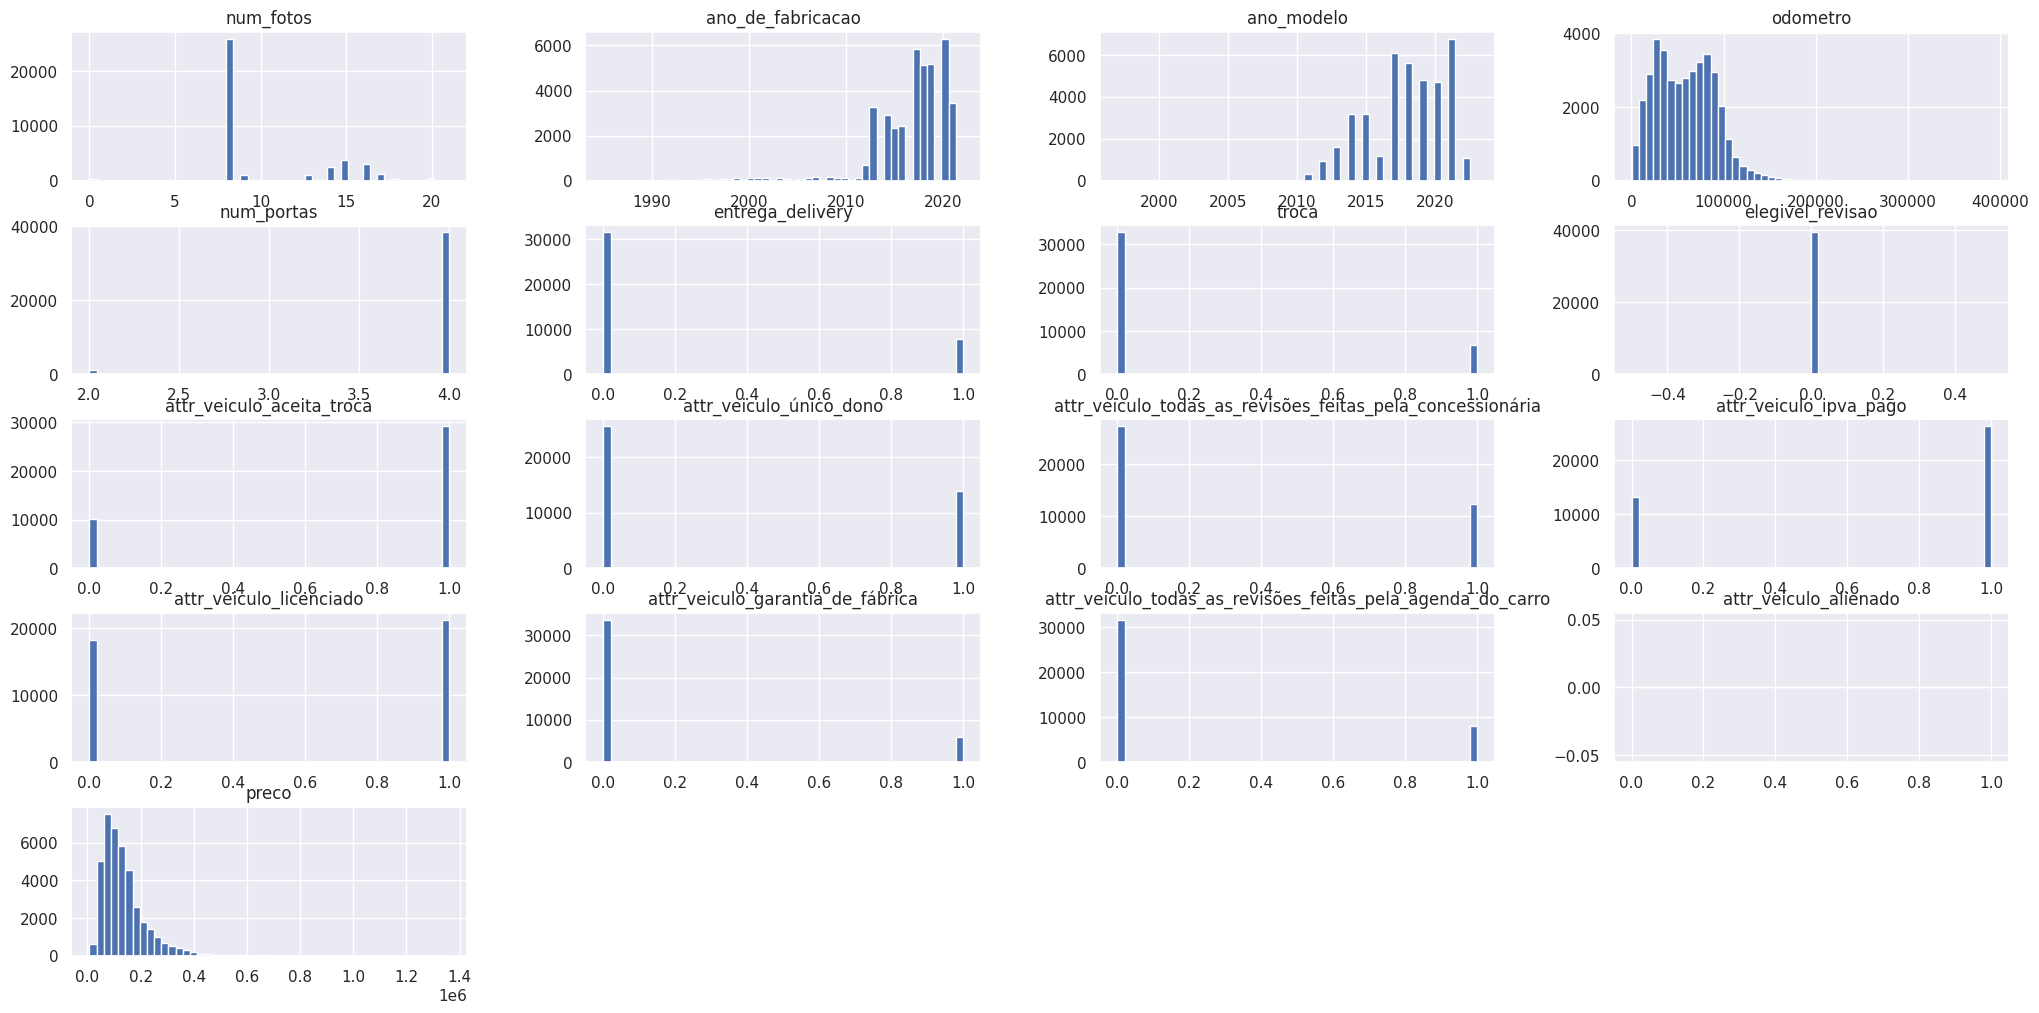

In [20]:
# check numerical features distribution
num_attributes.hist(bins = 50);

### Categorical Attributes

In [21]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

ID                 39446
marca                 41
modelo               473
versao              2058
cambio                 7
tipo                   8
blindado               2
cor                    8
tipo_vendedor          2
cidade_vendedor      648
estado_vendedor       25
tipo_anuncio           4
dtype: int64

In [ ]:
cate_attributes.marca.value_counts()

In [ ]:
cate_attributes.modelo.value_counts()

In [ ]:
cate_attributes.versao.value_counts()

In [ ]:
cate_attributes.cambio.value_counts()

In [ ]:
cate_attributes.tipo.value_counts()

In [ ]:
cate_attributes.blindado.value_counts()

In [ ]:
cate_attributes.cor.value_counts()

In [ ]:
cate_attributes.tipo_vendedor.value_counts()

In [ ]:
cate_attributes.cidade_vendedor.value_counts()

In [ ]:
cate_attributes.estado_vendedor.value_counts()

In [ ]:
cate_attributes.tipo_anuncio.value_counts()

# FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

In [23]:
df2.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,0,0,0,1,0,1,1,1,0,1,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,0,0,0,1,0,1,1,0,0,1,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,1,1,0,1,0,0,0,0,0,0,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,0,0,0,1,0,1,0,0,0,0,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,0,0,0,1,0,1,0,0,0,1,NaN,255164.344178


In [ ]:
df2.columns

## Hypothesis Mindmap

## Creating Hypothesis

## Final Hypothesis List

## Feature Engineering

# VARIABLE FILTERING

In [122]:
df3 = df2.copy()

## Line Filtering

## Columns Selection

In [ ]:
df3.columns

In [123]:
# primeiro momento deletar algumas features para agilizar o primeiro ciclo

# marca
# modelo
# versao
# cidade_vendedor

df3 = df3.drop(['marca', 'modelo', 'versao','elegivel_revisao' ,'cidade_vendedor', 'estado_vendedor','attr_veiculo_alienado' ], axis = 1)


# EXPLORATORY DATA ANALYSIS (EDA)

In [124]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

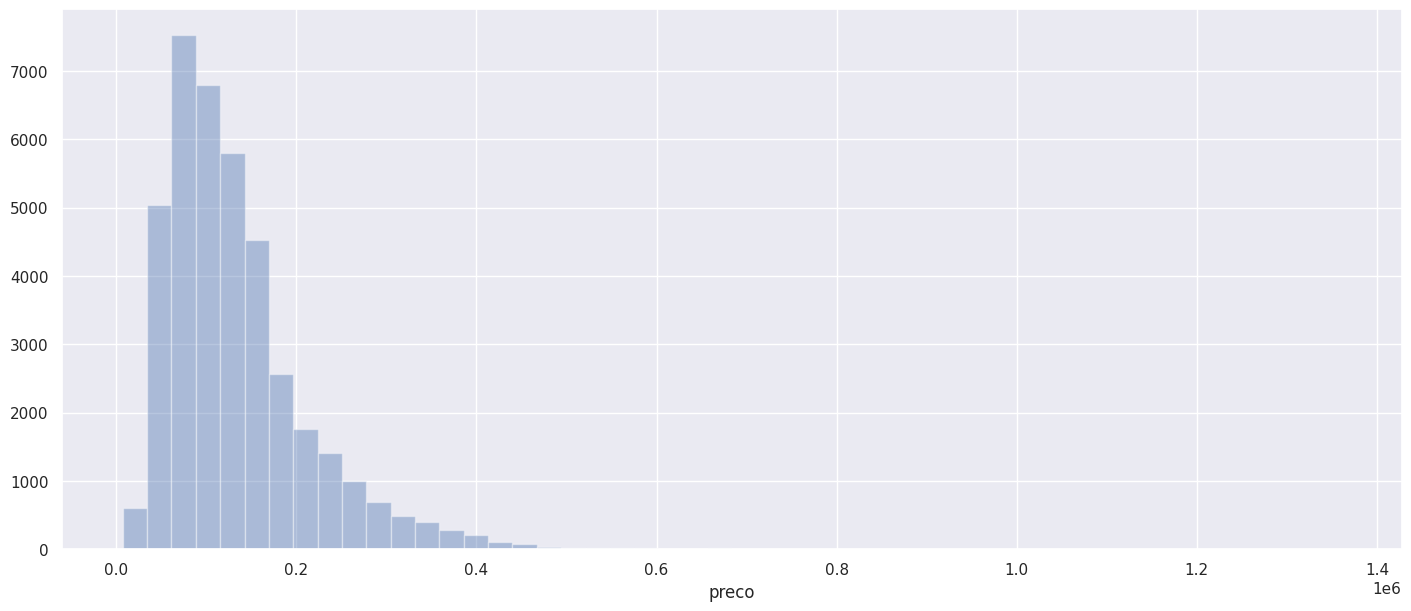

In [28]:
# plot target variable distribution
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['preco'], kde = False);
plt.style.use('tableau-colorblind10');

- It is not close to a normal distribution. 
- Skew far to the right.
- The more normal the response variable, the better the algorithm will perform. We might have to use log transformation later on it

### Numerical Variable

In [125]:
num_attributes = df4.select_dtypes( include = 'number')

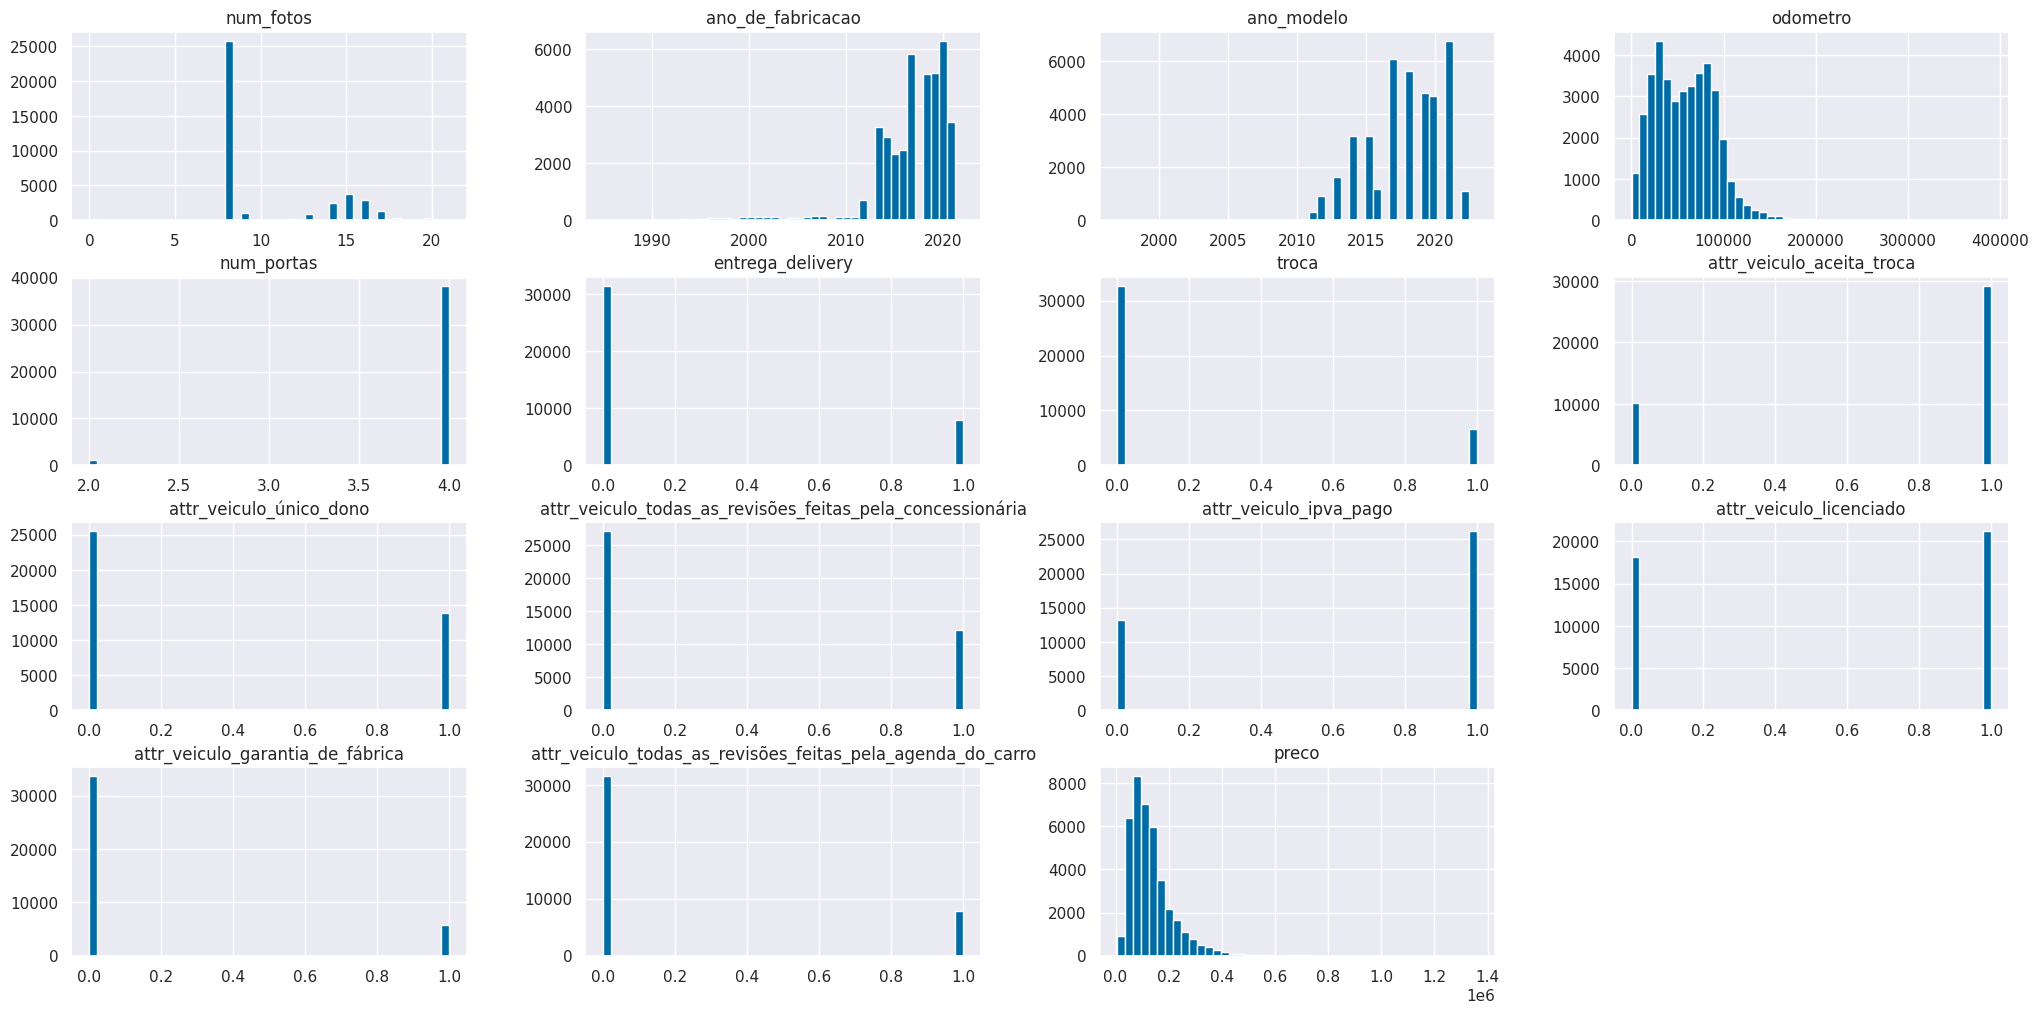

In [126]:
# histogram for numerical features
num_attributes.hist(bins = 45);
plt.style.use('tableau-colorblind10');

In [127]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,2.100000e+01,2.100000e+01,10.261801,8.000000,3.561070,0.831612,-0.397392
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,entrega_delivery,0.000000,1.000000e+00,1.000000e+00,0.201237,0.000000,0.400925,1.490425,0.221378
6,troca,0.000000,1.000000e+00,1.000000e+00,0.170005,0.000000,0.375637,1.757059,1.087311
7,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
8,attr_veiculo_único_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807
9,attr_veiculo_todas_as_revisões_feitas_pela_con...,0.000000,1.000000e+00,1.000000e+00,0.310272,0.000000,0.462605,0.820289,-1.327193


### Categorical Variable

In [128]:
cate_attributes = df4.select_dtypes( include = 'object')

In [33]:
cate_attributes.columns

Index(['ID', 'cambio', 'tipo', 'blindado', 'cor', 'tipo_vendedor',
       'estado_vendedor', 'tipo_anuncio'],
      dtype='object')

## Bivariate Analysis

## Multivariate Analysis

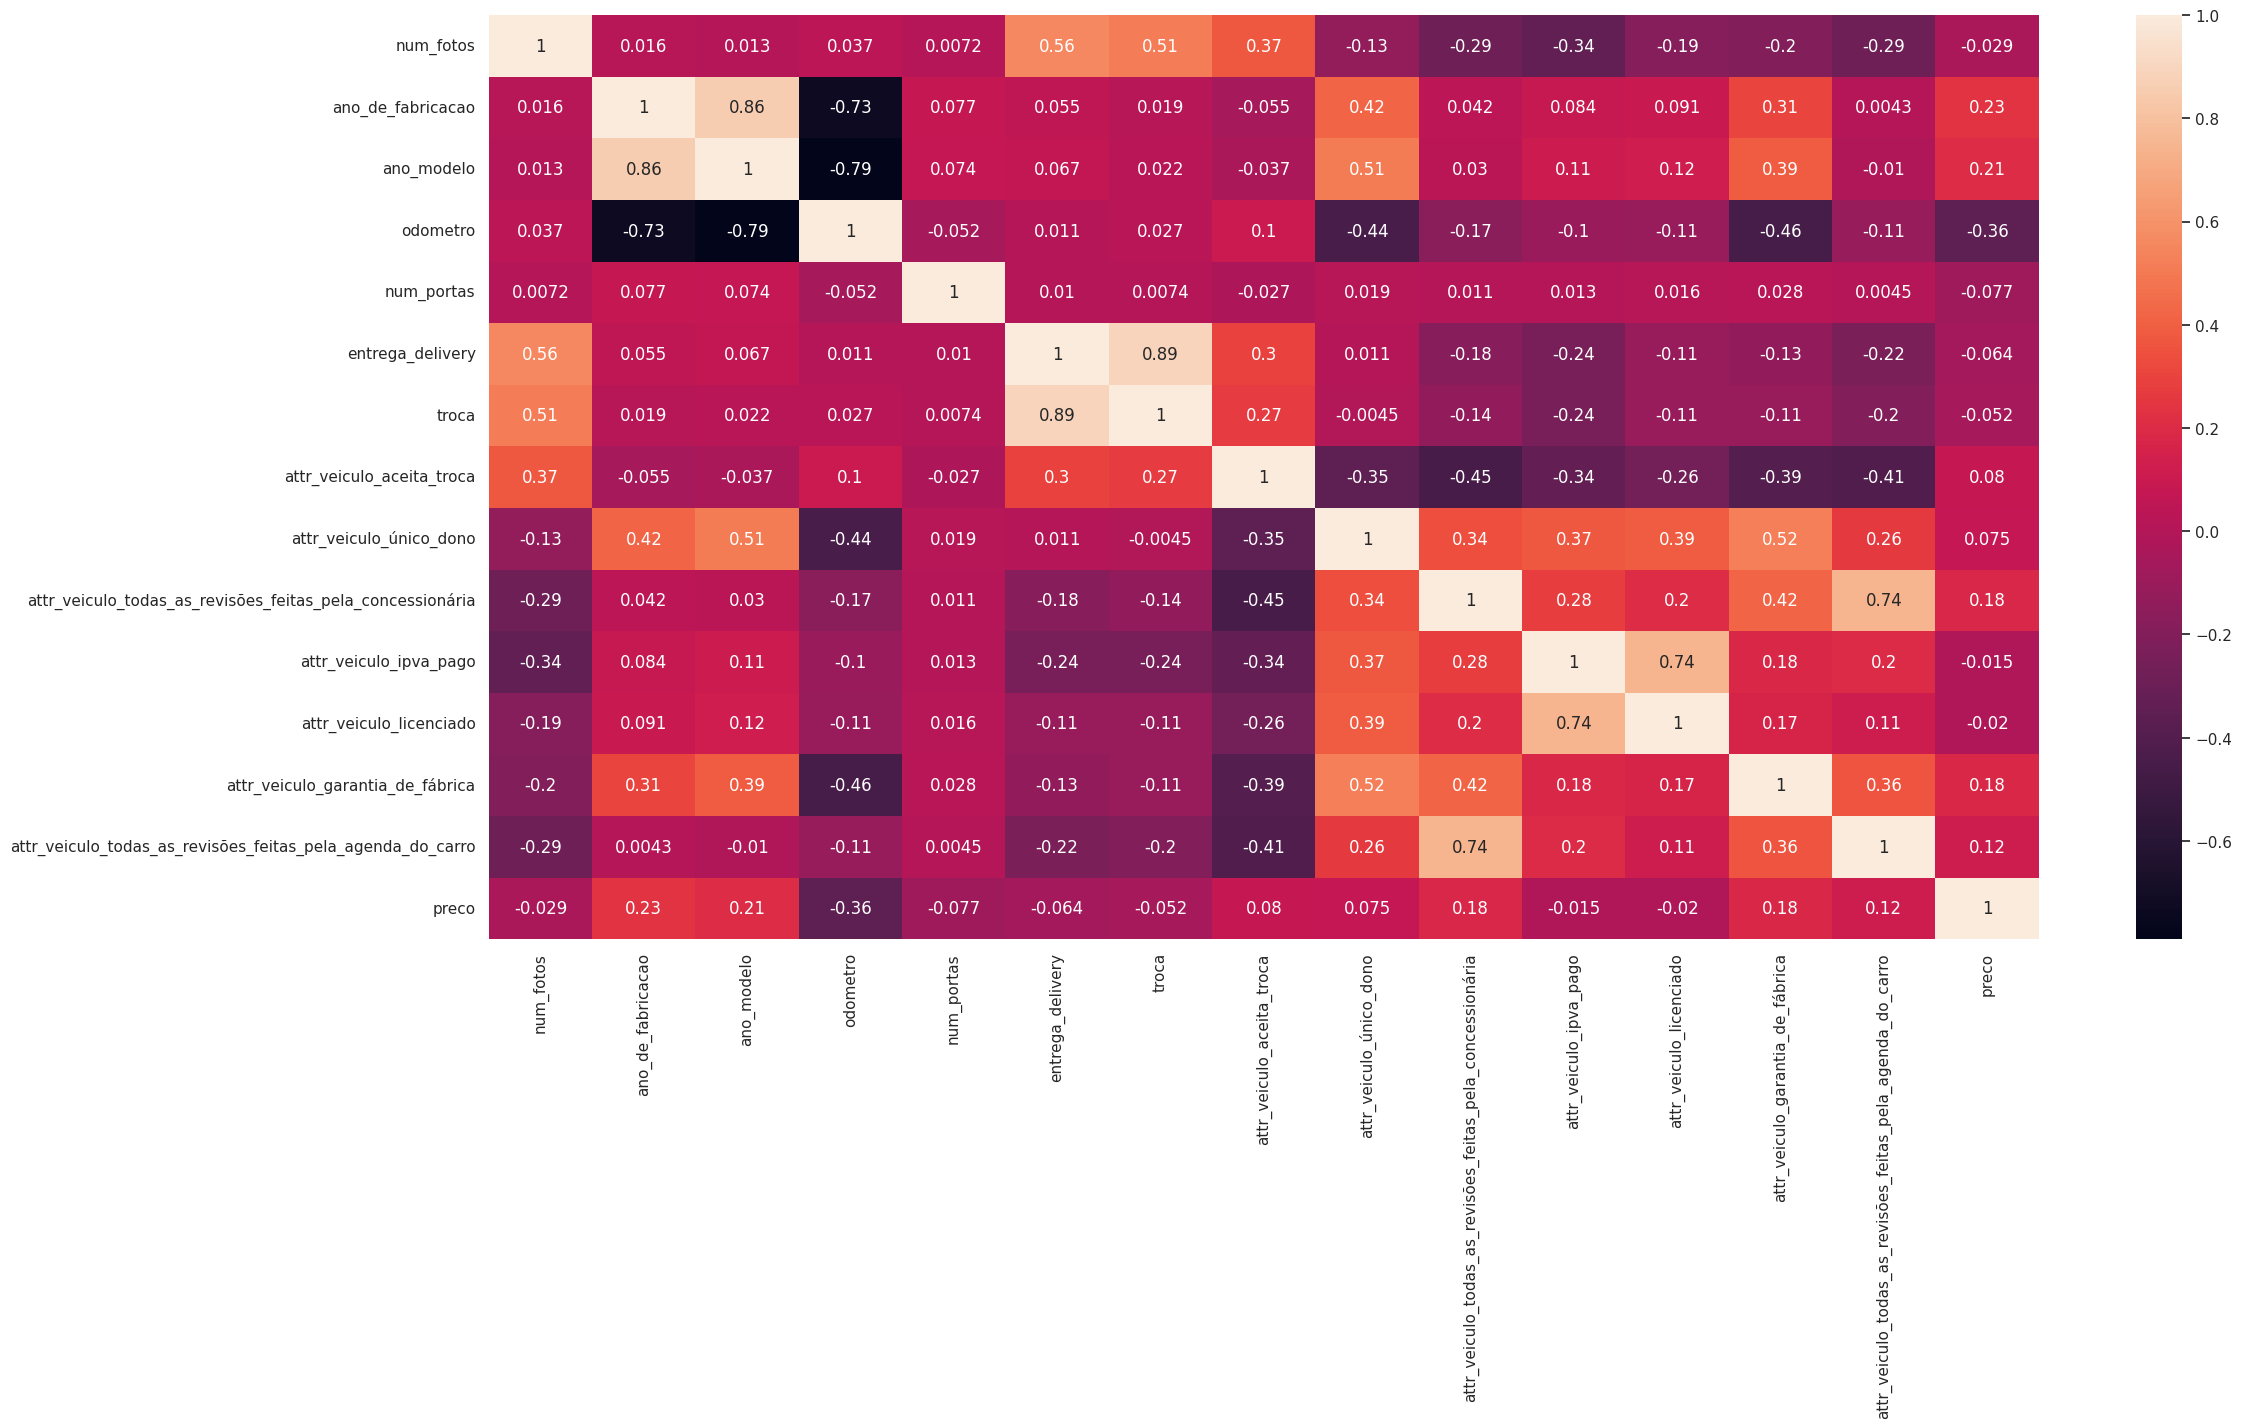

In [129]:
# correlation among all variables
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

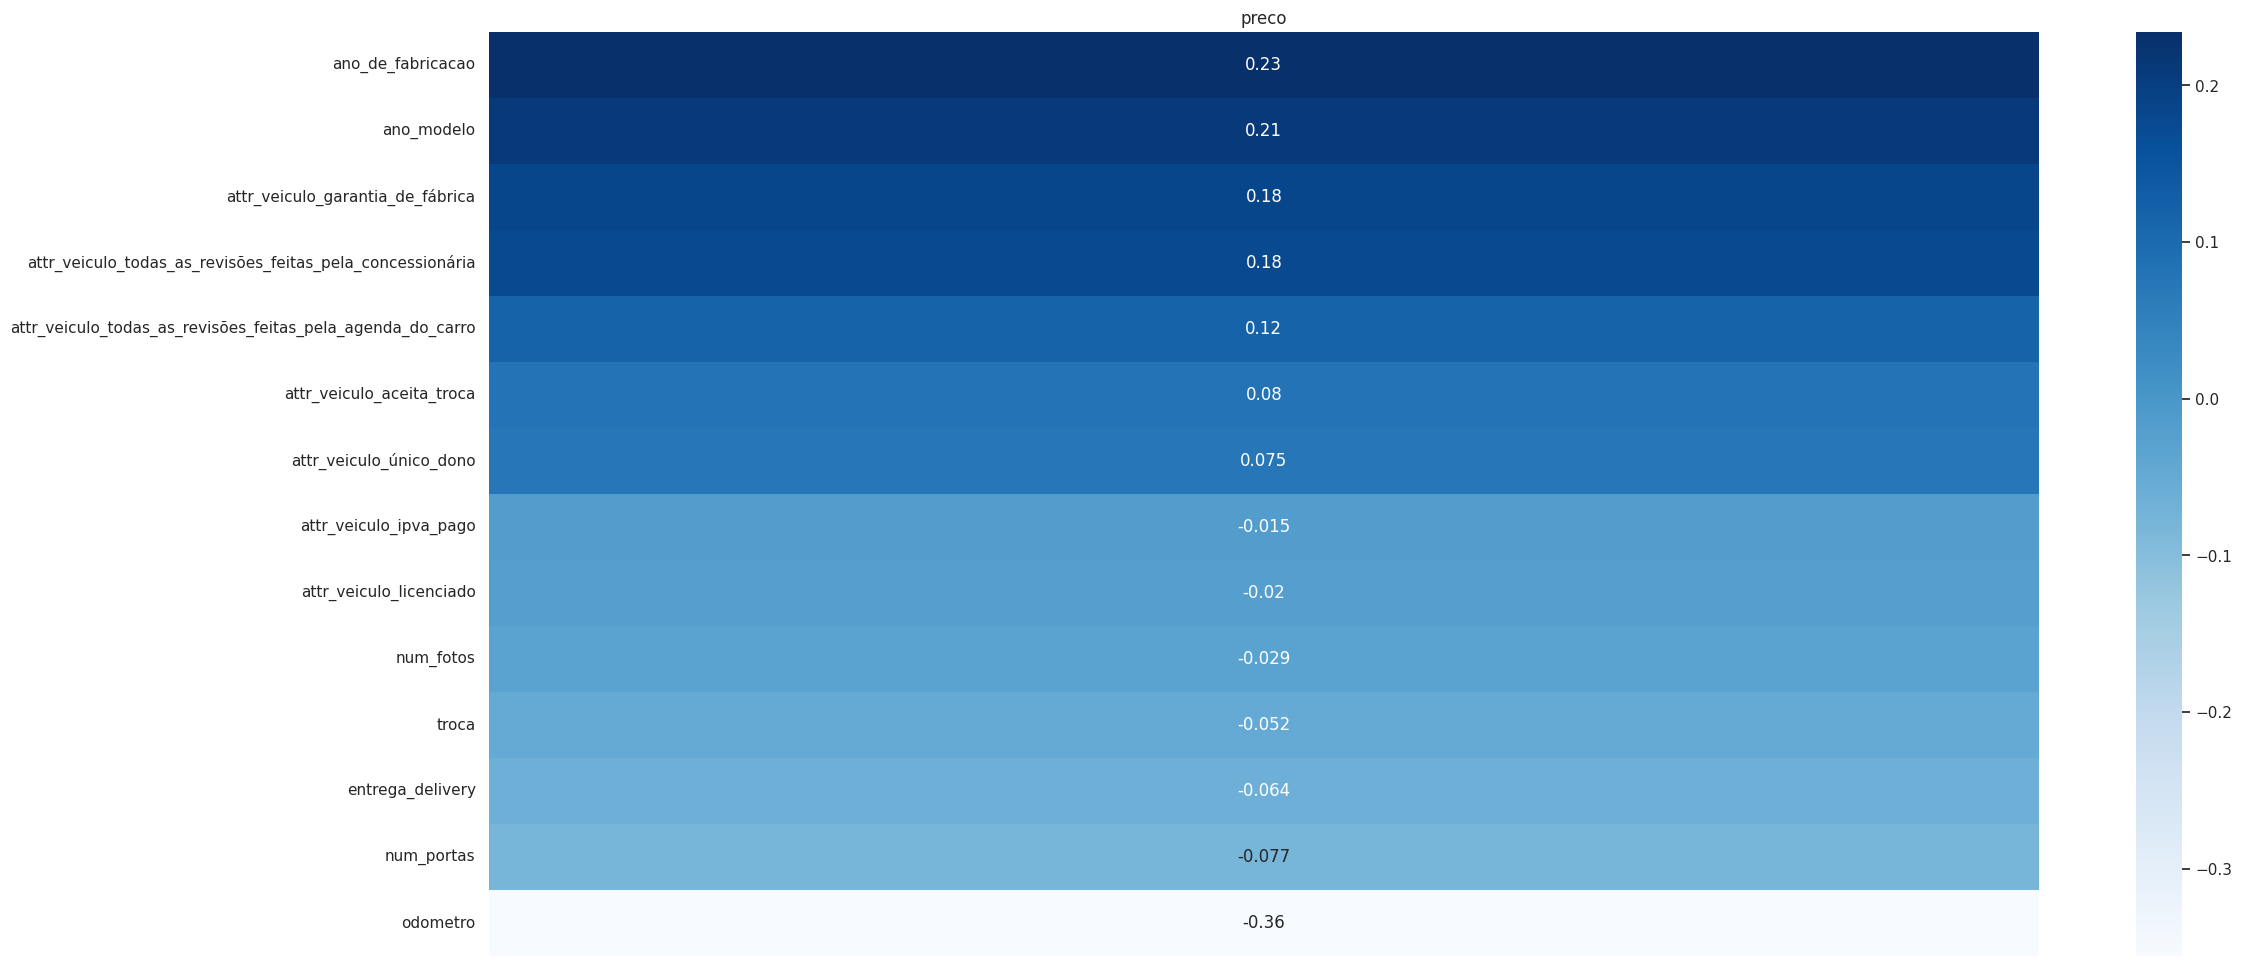

In [130]:
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Blues').set_title(col);
    
    return plot

plot_corr('preco');

# DATA PREPARATION

In [173]:
df5 = df4.copy()

The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

- Standard Scaler: applied on variables with a distribution shape similar to a normal distribution;
- Min-Max Scaler: applied on variables with low outliers influence;
- Robust Scaler: applied on variables with high outliers influence.

### split dataframe training and validation

- Here I'm going to split the dataframe into train and validation (Proportion 85/15)
- I'm doing that before data preparation to avoid data leakeage.
- Data prep will be applied into train dataset (fit_transform), and after that it will be applied in the validation dataset (only transform).
- The same will be done in the test data at the end of modelling.

In [ ]:
df_treino
df_teste
df_sample_submission

In [174]:
# drop target variable from training set
X = df5.drop('preco', axis = 1).copy()
y = df5['preco'].copy()

#apply stratief split to split train and test datasets, 85% for training and 15% for test
X_train, X_validation, y_train, y_validacao = train_test_split(X, y, test_size = 0.15, random_state = 42, 
                                                            shuffle = True)

#stratify = yes preservers class proportion 

In [133]:
# check the proportion of validation data datapoints
X_validation.shape[0]/df5.shape[0] * 100

15.000253511129138

In [134]:
# check the proportion of validation data datapoints
X_train.shape[0]/df5.shape[0] * 100

84.99974648887087

In [135]:
# check the proportion of validation data datapoints
y_train.shape[0]/df5.shape[0] * 100

84.99974648887087

In [136]:
# check the proportion of validation data datapoints
y_validacao.shape[0]/df5.shape[0] * 100

15.000253511129138

### Checking features outliers presence

In [175]:
num_attributes = X_train.select_dtypes( exclude = 'object')

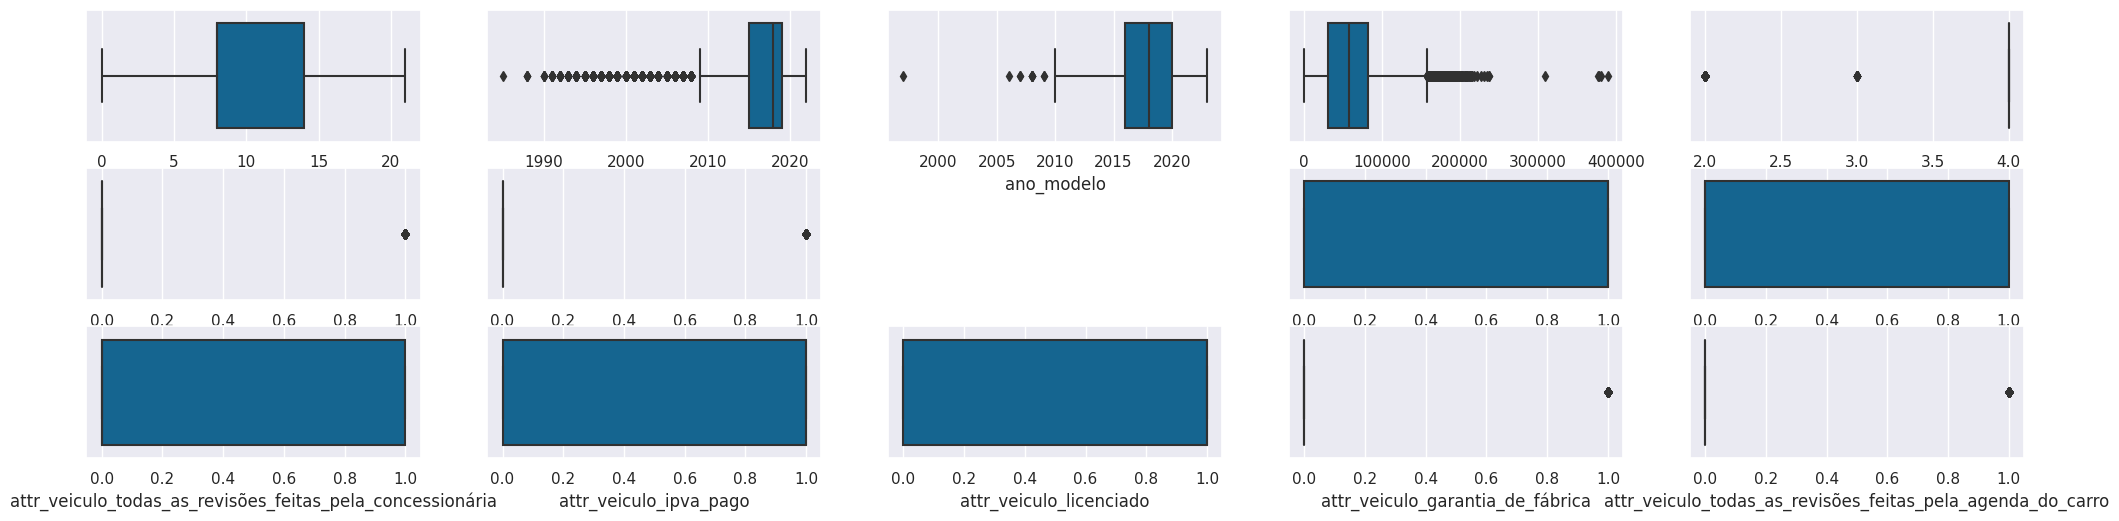

In [176]:
# plot boxplots features in order to check outliers presence
plt.subplot(6, 5, 1)
sns.boxplot(df5['num_fotos'])

plt.subplot(6, 5, 2)
sns.boxplot(df5['ano_de_fabricacao'])

plt.subplot(6, 5, 3)
sns.boxplot(df5['ano_modelo'])

plt.subplot(6, 5, 4)
sns.boxplot(df5['odometro'])

plt.subplot(6, 5, 5)
sns.boxplot(df5['num_portas'])

plt.subplot(6, 5, 6)
sns.boxplot(df5['entrega_delivery'])

plt.subplot(6, 5, 7)
sns.boxplot(df5['troca'])

plt.subplot(6, 5, 9)
sns.boxplot(df5['attr_veiculo_aceita_troca'])

plt.subplot(6, 5, 10)
sns.boxplot(df5['attr_veiculo_único_dono'])

plt.subplot(6, 5, 11)
sns.boxplot(df5['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'])

plt.subplot(6, 5, 12)
sns.boxplot(df5['attr_veiculo_ipva_pago'])

plt.subplot(6, 5, 13)
sns.boxplot(df5['attr_veiculo_licenciado'])

plt.subplot(6, 5, 14)
sns.boxplot(df5['attr_veiculo_garantia_de_fábrica'])

plt.subplot(6, 5, 15)
sns.boxplot(df5['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])

fig.tight_layout()

## Feature Normalization

## Feature Rescaling

In [177]:
rs = RobustScaler()  #selection of the rescaling method is due to outliers
                     #same formula as minmaxScaler, but uses interquatis itervals as range, being robust to outliers

mms = MinMaxScaler() #super sensitive to outliers

#features for Robust Scalers
# ano_de_fabricacao
X_train['ano_de_fabricacao'] = rs.fit_transform( X_train[['ano_de_fabricacao']].values ) 
pickle.dump(rs, open(home_path+'/parameters/ano_de_fabricacao_scaler.pkl', 'wb'))

# ano_modelo
X_train['ano_modelo'] = rs.fit_transform( X_train[['ano_modelo']].values ) 
pickle.dump(rs, open(home_path+'/parameters/ano_modelo_scaler.pkl', 'wb'))

# odometro
X_train['odometro'] = rs.fit_transform( X_train[['odometro']].values ) 
pickle.dump(rs, open(home_path+'/parameters/odometro_scaler.pkl', 'wb'))

#Features for MinMaxScaler
# num_fotos
X_train['num_fotos'] = mms.fit_transform( X_train[['num_fotos']].values )
pickle.dump(mms, open(home_path + '/parameters/num_fotos_scaler.pkl', 'wb'))

# num_portas
X_train['num_portas'] = mms.fit_transform( X_train[['num_portas']].values )
pickle.dump(mms, open(home_path + '/parameters/num_portas_scaler.pkl', 'wb'))


## Feature Transformation

### Enconding

In [77]:
df5.tipo.value_counts()

Sedã                    21910
Hatchback                6570
Picape                   6426
Utilitário esportivo     4458
Perua/SW                   37
Cupê                       34
Minivan                    10
Conversível                 1
Name: tipo, dtype: int64

In [82]:
df5.blindado.value_counts()

N    39128
S      318
Name: blindado, dtype: int64

In [83]:
df5.cor.value_counts()

Branco      27919
Preto        6985
Prata        2359
Cinza        2174
Dourado         6
Vermelho        1
Azul            1
Verde           1
Name: cor, dtype: int64

In [84]:
df5.tipo_vendedor.value_counts()

PF    23857
PJ    15589
Name: tipo_vendedor, dtype: int64

In [85]:
df5.estado_vendedor.value_counts()

São Paulo (SP)              21794
Rio de Janeiro (RJ)          3384
Paraná (PR)                  3380
Santa Catarina (SC)          3119
Minas Gerais (MG)            2350
Rio Grande do Sul (RS)       2191
Goiás (GO)                   1043
Bahia (BA)                    827
Pernambuco (PE)               411
Alagoas (AL)                  171
Paraíba (PB)                  147
Rio Grande do Norte (RN)      119
Pará (PA)                     107
Ceará (CE)                     87
Amazonas (AM)                  66
Mato Grosso (MT)               48
Mato Grosso do Sul (MS)        46
Acre (AC)                      40
Tocantins (TO)                 34
Espírito Santo (ES)            29
Sergipe (SE)                   29
Piauí (PI)                      9
Maranhão (MA)                   7
Rondônia (RO)                   5
Roraima (RR)                    3
Name: estado_vendedor, dtype: int64

In [86]:
df5.tipo_anuncio.value_counts()

Pessoa Física                       23949
Loja                                13182
Concessionária                       2310
Acessórios e serviços para autos        5
Name: tipo_anuncio, dtype: int64

In [121]:
df5.cambio.value_counts()

Automática               30073
Manual                    6631
CVT                       2391
Automatizada               192
Automatizada DCT            71
Semi-automática             56
Automática Sequencial       32
Name: cambio, dtype: int64

In [ ]:
CVT, Automatizada, Automatizada DCT, Semi-automática , Automática Sequencial

In [178]:
le = LabelEncoder()
# tipo
X_train = pd.get_dummies(X_train, prefix = ['tipo'], columns = ['tipo'], dtype = 'int64' )

# cambio
X_train = pd.get_dummies(X_train, prefix = ['cambio'], columns = ['cambio'], dtype = 'int64' )

# blindado
X_train['blindado'] = X_train['blindado'].apply(lambda x: 1 if x=='S' else 0)

# cor
X_train['cor'] = le.fit_transform( X_train['cor'] )
pickle.dump(le, open(home_path+'/parameters/cor_scaler.pkl', 'wb'))

# tipo_vendedor
X_train['tipo_vendedor'] = X_train['tipo_vendedor'].apply(lambda x: 1 if x=='PF' else 0)

# tipo_anuncio
X_train = pd.get_dummies(X_train, prefix = ['tipo_anuncio'], columns = ['tipo_anuncio'], dtype = 'int64' )

In [179]:
X_train.head()

,ID,num_fotos,ano_de_fabricacao,ano_modelo,odometro,num_portas,blindado,cor,tipo_vendedor,entrega_delivery,troca,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,tipo_Conversível,tipo_Cupê,tipo_Hatchback,tipo_Minivan,tipo_Perua/SW,tipo_Picape,tipo_Sedã,tipo_Utilitário esportivo,cambio_Automatizada,cambio_Automatizada DCT,cambio_Automática,cambio_Automática Sequencial,cambio_CVT,cambio_Manual,cambio_Semi-automática,tipo_anuncio_Acessórios e serviços para autos,tipo_anuncio_Concessionária,tipo_anuncio_Loja,tipo_anuncio_Pessoa Física
14957,294300303050203815319060830024895312601,0.380952,0.75,0.75,-0.387274,1.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
17446,158800267714501656003447437314728435739,0.761905,-0.50,-0.25,0.152167,1.0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
17739,281630392443409752669565679587092820289,0.714286,-0.25,-0.25,-0.067078,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
32951,279382752368206963112128320265905104974,0.714286,0.75,0.75,-0.810708,1.0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
38450,226980477166293633652611305969335180471,0.809524,-0.25,0.00,0.530219,1.0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [180]:
X_train.shape

(33529, 37)

### Target Variable Transformation

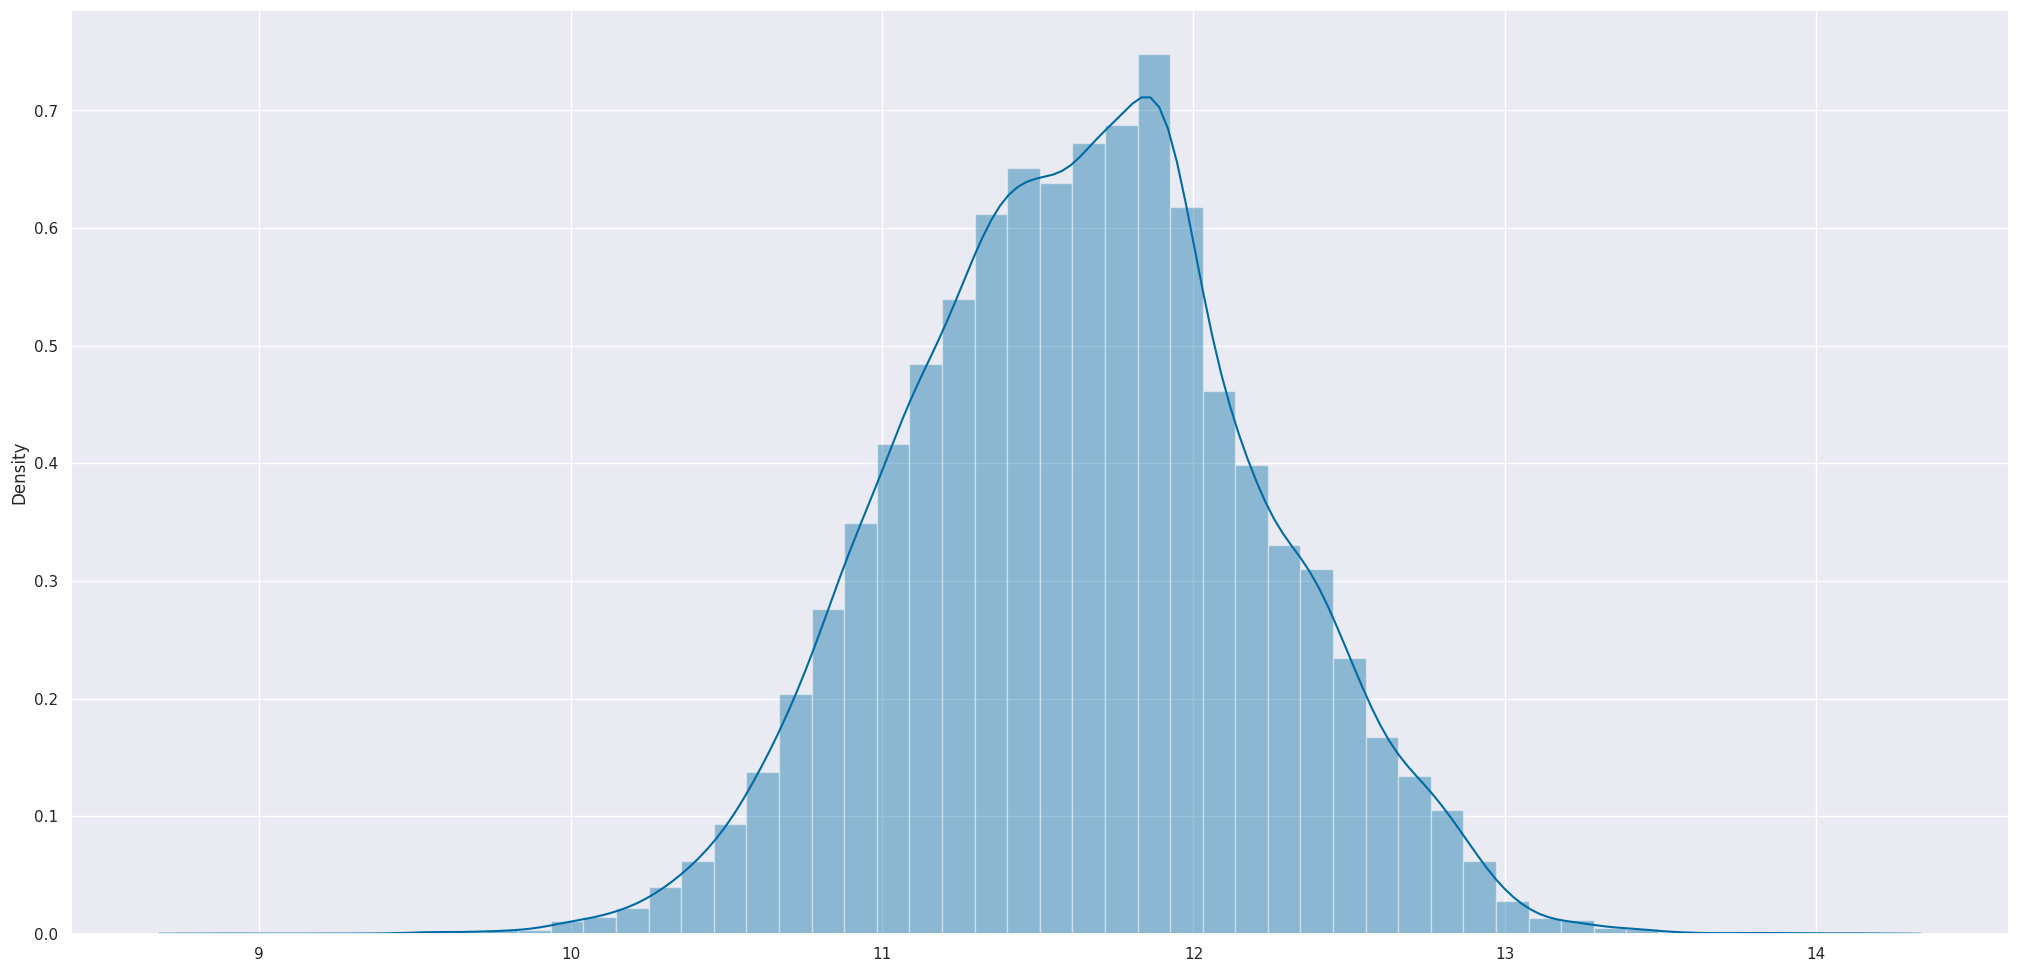

In [181]:
y_train = np.log1p( y_train.ravel() )
sns.distplot(y_train);

### Nature Transformation

## Apply Transformations in the Validation dataset

In [182]:
# loading scalers

#Robust Scaler 
ano_de_fabricacao_scaler  = pickle.load(open(home_path + '/parameters/ano_de_fabricacao_scaler.pkl', 'rb'))
ano_modelo_scaler         = pickle.load(open(home_path + '/parameters/ano_modelo_scaler.pkl', 'rb'))
odometro_scaler           = pickle.load(open(home_path + '/parameters/odometro_scaler.pkl', 'rb'))


#MinMax Scaler 
num_fotos_scaler   = pickle.load(open(home_path + 'parameters/num_fotos_scaler.pkl', 'rb'))
num_portas_scaler  = pickle.load(open(home_path + 'parameters/num_portas_scaler.pkl', 'rb'))


#Label enconder
cor_scaler         = pickle.load(open(home_path + 'parameters/cor_scaler.pkl', 'rb'))

In [183]:
# Applying all transformations on validation dataset
#Validation dataset features transform - Robust Scaler

X_validation['ano_de_fabricacao'] = ano_de_fabricacao_scaler.transform( X_validation[['ano_de_fabricacao']].values ) 
X_validation['ano_modelo']  = ano_modelo_scaler.transform( X_validation[['ano_modelo']].values ) 
X_validation['odometro']  = odometro_scaler.transform( X_validation[['odometro']].values ) 

##Validation dataset features transform - MinMaxScaler
# num_fotos
X_validation['num_fotos'] = num_fotos_scaler.transform( X_validation[['num_fotos']].values ) 
X_validation['num_portas']  = num_portas_scaler.transform( X_validation[['num_portas']].values ) 


##Validation dataset features transform - Label Enconder
X_validation['cor'] = cor_scaler.transform( X_validation['cor'] )

# tipo
X_validation = pd.get_dummies(X_validation, prefix = ['tipo'], columns = ['tipo'], dtype = 'int64' )

# cambio
X_validation = pd.get_dummies(X_validation, prefix = ['cambio'], columns = ['cambio'], dtype = 'int64' )

# blindado
X_validation['blindado'] = X_validation['blindado'].apply(lambda x: 1 if x=='S' else 0)

# tipo_vendedor
X_validation['tipo_vendedor'] = X_validation['tipo_vendedor'].apply(lambda x: 1 if x=='PF' else 0)

# tipo_anuncio
X_validation = pd.get_dummies(X_validation, prefix = ['tipo_anuncio'], columns = ['tipo_anuncio'], dtype = 'int64' )


In [166]:
# new y_train with weekly sales rescaled
y_validation = np.log1p( y_validacao.ravel())

In [168]:
X_validation.head()

,ID,num_fotos,ano_de_fabricacao,ano_modelo,odometro,num_portas,blindado,cor,tipo_vendedor,entrega_delivery,troca,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,tipo_Cupê,tipo_Hatchback,tipo_Minivan,tipo_Perua/SW,tipo_Picape,tipo_Sedã,tipo_Utilitário esportivo,cambio_Automatizada,cambio_Automatizada DCT,cambio_Automática,cambio_Automática Sequencial,cambio_CVT,cambio_Manual,cambio_Semi-automática,tipo_anuncio_Acessórios e serviços para autos,tipo_anuncio_Concessionária,tipo_anuncio_Loja,tipo_anuncio_Pessoa Física
22466,13518783164498355150900635905895481162,0.380952,0.75,0.75,-0.731235,1.0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
35971,299896161723793383246777788797566040330,0.857143,0.75,0.75,-0.085148,0.0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
29745,316180649972302128246133616457018378621,0.380952,0.00,0.25,-0.490275,1.0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
37622,222527157104148385909188217274642813298,0.761905,0.25,0.50,-0.639033,1.0,0,2,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3568,160460343059850745858546502614838368036,0.380952,0.25,0.25,0.092774,1.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [184]:
X_validation.shape

(5917, 36)

In [185]:
X_validation.columns

Index(['ID', 'num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'odometro',
       'num_portas', 'blindado', 'cor', 'tipo_vendedor', 'entrega_delivery',
       'troca', 'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'tipo_Cupê', 'tipo_Hatchback', 'tipo_Minivan', 'tipo_Perua/SW',
       'tipo_Picape', 'tipo_Sedã', 'tipo_Utilitário esportivo',
       'cambio_Automatizada', 'cambio_Automatizada DCT', 'cambio_Automática',
       'cambio_Automática Sequencial', 'cambio_CVT', 'cambio_Manual',
       'cambio_Semi-automática',
       'tipo_anuncio_Acessórios e serviços para autos',
       'tipo_anuncio_Concessionária', 'tipo_anuncio_Loja',
       'tipo_anuncio_Pessoa Física'],
      dtype='object')

In [ ]:
['ID', 'num_fotos', 
 'ano_de_fabricacao', 
 'ano_modelo', 
 'odometro',
'num_portas', 
 'blindado', 
 'cor', 
 'tipo_vendedor', 
'entrega_delivery',
'troca', 
'attr_veiculo_aceita_troca', 
'attr_veiculo_único_dono',
'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
'attr_veiculo_garantia_de_fábrica',
'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
'tipo_Cupê', 'tipo_Hatchback', 'tipo_Minivan', 
'tipo_Perua/SW',
'tipo_Picape', 'tipo_Sedã', 'tipo_Utilitário esportivo',
'cambio_Automatizada', 
 'cambio_Automatizada DCT', 
 'cambio_Automática',
'cambio_Automática Sequencial', 
'cambio_CVT', 'cambio_Manual',
'cambio_Semi-automática',
'tipo_anuncio_Acessórios e serviços para autos',
'tipo_anuncio_Concessionária', 
'tipo_anuncio_Loja',
'tipo_anuncio_Pessoa Física']

In [169]:
X_train.head()

,ID,num_fotos,ano_de_fabricacao,ano_modelo,odometro,num_portas,blindado,cor,tipo_vendedor,entrega_delivery,troca,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,tipo_Conversível,tipo_Cupê,tipo_Hatchback,tipo_Minivan,tipo_Perua/SW,tipo_Picape,tipo_Sedã,tipo_Utilitário esportivo,cambio_Automatizada,cambio_Automatizada DCT,cambio_Automática,cambio_Automática Sequencial,cambio_CVT,cambio_Manual,cambio_Semi-automática,tipo_anuncio_Acessórios e serviços para autos,tipo_anuncio_Concessionária,tipo_anuncio_Loja,tipo_anuncio_Pessoa Física
14957,294300303050203815319060830024895312601,0.380952,0.75,0.75,-0.387274,1.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
17446,158800267714501656003447437314728435739,0.761905,-0.50,-0.25,0.152167,1.0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
17739,281630392443409752669565679587092820289,0.714286,-0.25,-0.25,-0.067078,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
32951,279382752368206963112128320265905104974,0.714286,0.75,0.75,-0.810708,1.0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
38450,226980477166293633652611305969335180471,0.809524,-0.25,0.00,0.530219,1.0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [186]:
X_train = X_train.drop('tipo_Conversível', axis = 1)

In [187]:
X_train.shape

(33529, 36)

# FEATURE SELECTION

In [188]:
df6 = X_train.copy()

## Feature Selector (boruta?)

## Best Features

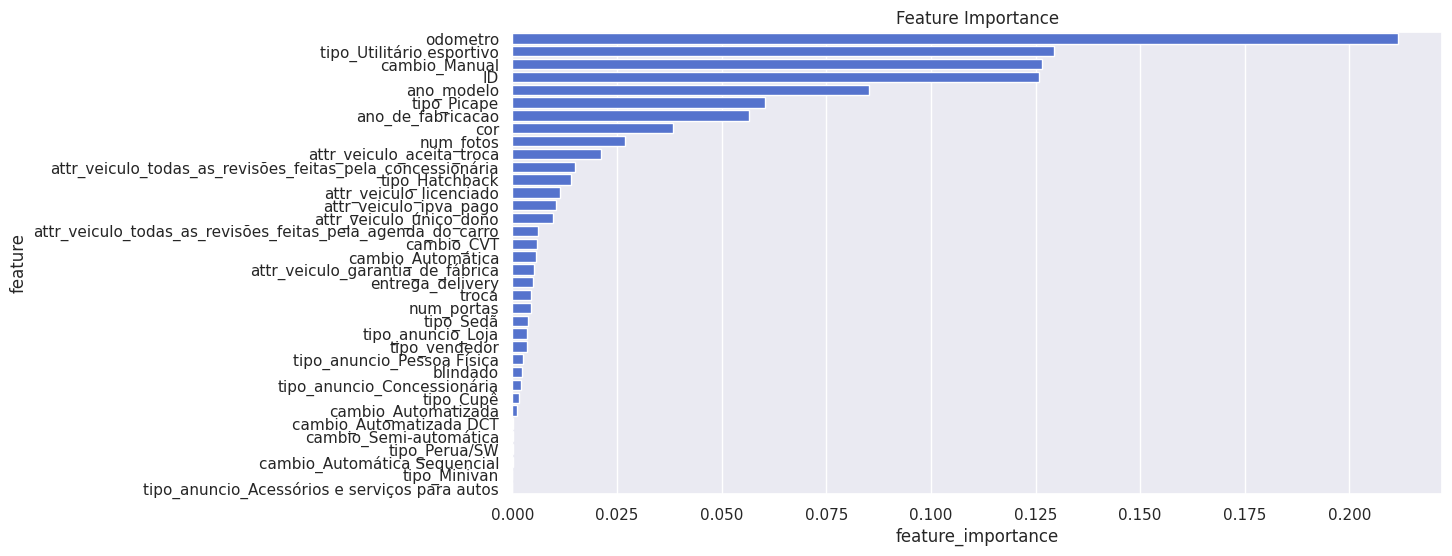

In [196]:
# train random forest classifier
rf = RandomForestRegressor(n_estimators = 200, n_jobs =-1, random_state = 42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [199]:
feat_imp

,feature,feature_importance
0,odometro,0.211634
1,tipo_Utilitário esportivo,0.129511
2,cambio_Manual,0.126541
3,ID,0.125908
4,ano_modelo,0.085248
5,tipo_Picape,0.060341
6,ano_de_fabricacao,0.056440
7,cor,0.038270
8,num_fotos,0.026802
9,attr_veiculo_aceita_troca,0.021132


In [205]:
cols_selected = ['odometro', 'tipo_Utilitário esportivo', 'cambio_Manual','ID',
                 'ano_modelo', 'tipo_Picape', 'ano_de_fabricacao', 'cor', 'num_fotos', 'attr_veiculo_aceita_troca',
                 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária', 'tipo_Hatchback', 'attr_veiculo_licenciado',
                 'attr_veiculo_ipva_pago', 'attr_veiculo_único_dono', 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
                 'cambio_CVT', 'cambio_Automática', 'attr_veiculo_garantia_de_fábrica','entrega_delivery', 'troca', 'num_portas',
                 'tipo_Sedã', 'tipo_anuncio_Loja', 'tipo_vendedor', 'tipo_anuncio_Pessoa Física', 'blindado', 'tipo_anuncio_Concessionária', 
                 'tipo_Cupê', 'cambio_Automatizada', 'cambio_Automatizada DCT', 'cambio_Semi-automática', 'tipo_Perua/SW', 'cambio_Automática Sequencial',
                 'tipo_Minivan', 'tipo_anuncio_Acessórios e serviços para autos']

## Manual Feature Selection

In [ ]:
# cols_selected = ['odometro', 'tipo_Utilitário esportivo', 'cambio_Manual','ID',
#                  'ano_modelo', 'tipo_Picape', 'ano_de_fabricacao', 'cor', 'num_fotos', 'attr_veiculo_aceita_troca',
#                  'attr_veiculo_todas_as_revisões_feitas_pela_concessionária', 'tipo_Hatchback', 'attr_veiculo_licenciado',
#                  'attr_veiculo_ipva_pago', 'attr_veiculo_único_dono', 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
#                  'cambio_CVT', 'cambio_Automática', 'attr_veiculo_garantia_de_fábrica','entrega_delivery', 'troca', 'num_portas',
#                  'tipo_Sedã', 'tipo_anuncio_Loja', 'tipo_vendedor', 'tipo_anuncio_Pessoa Física	', 'blindado', 'tipo_anuncio_Concessionária', 
#                  'tipo_Cupê', 'cambio_Automatizada', 'cambio_Automatizada DCT', 'cambio_Semi-automática', 'tipo_Perua/SW', 'cambio_Automática Sequencial',
#                  'tipo_Minivan', 'tipo_anuncio_Acessórios e serviços para autos']

# MACHINE LEARNING ALGORITHM MODELS

**Four different algorithms are going to be used to predict the target variable:**

- **Average:** averaging model is the model we use most in everyday life, it will always predict the average. It is useful as it is a comparative basis for implementing other models

- **Linear Regression:** Regression analysis allows you to understand the strength of relationships between variables. Tells you what predictors in a model are statistically significant and which are not. It is less of a black box and is easier to communicate.

- **Random Forest:** it is a tree based model build with multiple ensamble decision trees created with the bagging method. Then, all the classifiers take a weighted vote on their predictions. Since the algorithm goal is not trying to find a linear function to describe the event, it works for problems with more complex behaviour

- **XGBoost:** it is also a tree based model but they are built in a different way. While Random Forests builds each tree independently, XGBoost builds one tree at the time learning with its predecessor. Therefore, this algorithm doesn't combine results at the end of the process by taking majority votes, it combines the results along the way

- **LightGBM:** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

 - Faster training speed and higher efficiency.
 - Lower memory usage.
 - Better accuracy.
 - Support of parallel, distributed, and GPU learning.
 - Capable of handling large-scale data.

In [207]:
# Applying selected features by boruta on train and validation datasets
x_train = X_train[ cols_selected ].copy() #selecting only the columns selected by boruta
x_validation = X_validation[ cols_selected ].copy()

## Modelo 1

## Modelo 2

## Modelo 3

## Modelo 4

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT